# Plotting Sentinel 5P Data

[Sentinel 5P](http://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-5P) is one of [ESA](https://www.esa.int/)'s earth observation satellites developed as part of the [Copernicus](https://www.esa.int/Applications/Observing_the_Earth/Copernicus) program.

It is dedicated to monitor air pollution and use a spectrometer to measure ozone, methane, nitrogen dioxide and other gases in the atmosphere.

I currently work with a small group on a project called [Emissions API](https://emissions-api.org) which is trying to create an web API to make the it easier to access the data of Sentinel 5P and its successor [Sentinel 5](https://earth.esa.int/web/guest/missions/esa-future-missions/sentinel-5). While working we created some small libraries for communicating with the servers of the ESA and for processing the data from the satellite. To verify that those libraries are working fine and to understand the data, it is often useful to visualize the results. So I would like to share some of those plottings with you.

## Preparation

We are using the [Sentinel-5P Downloader](https://pypi.org/project/sentinel5dl/) to download the data from the ESA and [Sentinel-5 Algorithms](https://pypi.org/project/s5a/) to read and preprocess those data.

For plotting we are using [GeoPandas](http://geopandas.org/) which is internally using [Matplotlib](https://matplotlib.org/) and [Descartes](https://pypi.org/project/descartes/).

```bash
$ pip install geopandas s5a sentinel5dl matplotlib descartes
```

Now we download the data using the `sentinel5dl` binary. 

```bash
$ mkdir -p data/S5P_OFFL_L2__NO2____
$ sentinel5dl --begin-ts '2019-12-31' --end-ts '2020-01-02' \
    --mode Offline --product 'L2__NO2___' data/S5P_OFFL_L2__NO2____
```

I chose to use nitrogen dioxide and New Year's Eve, since I hoped to find a lot of pollution from the fireworks.

The result should look like this

```bash
$ ls data/S5P_OFFL_L2__NO2____
S5P_OFFL_L2__NO2____20191231T011147_20191231T025317_11473_01_010302_20200101T180133.nc
S5P_OFFL_L2__NO2____20191231T011147_20191231T025317_11473_01_010302_20200101T180133.nc.md5sum
S5P_OFFL_L2__NO2____20191231T025317_20191231T043447_11474_01_010302_20200101T192226.nc
S5P_OFFL_L2__NO2____20191231T025317_20191231T043447_11474_01_010302_20200101T192226.nc.md5sum
...
S5P_OFFL_L2__NO2____20200101T192916_20200101T211046_11498_01_010302_20200103T121312.nc
S5P_OFFL_L2__NO2____20200101T192916_20200101T211046_11498_01_010302_20200103T121312.nc.md5sum
S5P_OFFL_L2__NO2____20200101T211046_20200101T225216_11499_01_010302_20200103T140339.nc
S5P_OFFL_L2__NO2____20200101T211046_20200101T225216_11499_01_010302_20200103T140339.nc.md5sum
```

We are interested in the `*.nc` files. These are in the [NetCDF](https://de.wikipedia.org/wiki/NetCDF) format and containing a lot of data gathered from the satellite. If you are interessted, you can explore those files for example with a tool like [Panoply](https://www.giss.nasa.gov/tools/panoply/). To make it easier, we are using `s5a` to load the data, since we only need a very small subset.

In [1]:
import s5a

data = s5a.load_ncfile(
    'data/S5P_OFFL_L2__NO2____/S5P_OFFL_L2__NO2____20191231T025317_20191231T043447_11474_01_010302_20200101T192226.nc'
)
data

timestamp  quality     value  longitude  \
0       2019-12-31 03:17:57.205000+00:00     0.07 -0.000011 -15.975651   
1       2019-12-31 03:17:57.205000+00:00     0.07 -0.000019 -16.178890   
2       2019-12-31 03:17:58.045000+00:00     0.07 -0.000006 -15.965775   
3       2019-12-31 03:17:58.045000+00:00     0.07 -0.000012 -16.169365   
4       2019-12-31 03:17:58.885000+00:00     0.07 -0.000010 -15.955670   
...                                  ...      ...       ...        ...   
1578390 2019-12-31 04:10:38.894000+00:00     0.03 -0.000070  91.619942   
1578391 2019-12-31 04:10:38.894000+00:00     0.03 -0.000045  91.716927   
1578392 2019-12-31 04:10:39.734000+00:00     0.03 -0.000052  91.440414   
1578393 2019-12-31 04:10:39.734000+00:00     0.03 -0.000070  91.538177   
1578394 2019-12-31 04:10:40.574000+00:00     0.03 -0.000075  91.358582   

          latitude  
0       -65.399246  
1       -65.418892  
2       -65.446426  
3       -65.466110  
4       -65.493546  
...            ...  
1578390  62.235840  
1578391  62.305752  
1578392  62.197773  
1578393  62.268784  
1578394  62.230633  

[1578395 rows x 5 columns]

One and a half millions points per data set is a lot. Luckily `s5a` does have some functionality to reduce this.
First note that every data point does have a `quality`. With `s5a` we can drop points with poor quality quite easily.

In [2]:
data = s5a.filter_by_quality(data)
len(data)

1416967

To reduce those points even more, `s5a` is using [Uber’s Hexagonal Hierarchical Spatial Index H3](https://eng.uber.com/h3/), which is a grid system partitioning the earth into hexagons. We calculate the H3 indices for every point, aggregate points with the same index by calculating the mean `value` and recalculate the `longitude` and `latitude` as the center of the hexagons. The `resolution` defines the size of the hexagons with a resolution of 5 partitioning the world into approximately 2 million unique hexagons. For more details information take a look at the [Table of Cell Areas for H3 Resolutions](https://uber.github.io/h3/#/documentation/core-library/resolution-table)

In [3]:
data = s5a.point_to_h3(data, resolution=4)
data = s5a.aggregate_h3(data)
data = s5a.h3_to_point(data)
data

/home/sven/devel/emissions-api/sentinel5p-plots/env/lib/python3.8/site-packages/s5a-0.3-py3.8.egg/s5a/__init__.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['h3'] = [h3.geo_to_h3(lat, lon, resolution)


h3                        timestamp  quality  \
0      840a985ffffffff 2019-12-31 04:08:16.097000+00:00     0.73   
1      840a987ffffffff 2019-12-31 04:08:14.417000+00:00     0.73   
2      840a98dffffffff 2019-12-31 04:08:21.137000+00:00     0.73   
3      840a9a1ffffffff 2019-12-31 04:08:03.498000+00:00     0.73   
4      840a9a3ffffffff 2019-12-31 04:08:02.658000+00:00     0.73   
...                ...                              ...      ...   
28080  84f3b65ffffffff 2019-12-31 03:28:02.832000+00:00     0.88   
28081  84f3b67ffffffff 2019-12-31 03:27:56.112000+00:00     0.88   
28082  84f3b69ffffffff 2019-12-31 03:28:07.032000+00:00     0.88   
28083  84f3b6bffffffff 2019-12-31 03:28:01.152000+00:00     0.88   
28084  84f3b6dffffffff 2019-12-31 03:28:07.872000+00:00     0.88   

              value   latitude   longitude  
0      2.829519e-05  57.072137  104.686948  
1      2.999278e-05  57.316137  105.233968  
2      2.933968e-05  57.206982  104.014777  
3      2.940455e-05  56.532274  105.496560  
4      4.276255e-05  56.772202  106.039642  
...             ...        ...         ...  
28080  1.086464e-06 -78.894170  154.567087  
28081  1.328647e-06 -79.219329  155.644712  
28082  4.191742e-07 -78.473878  157.304381  
28083  8.294408e-07 -78.789092  158.409090  
28084  9.172223e-07 -78.524756  155.437410  

[28085 rows x 6 columns]

So with those techniques we have reduced the number of points in this data set about approximately 88% and also have limit the total amount of points we have to plot for the whole world to approximately 2 millions.

Our last preparation will be converting the the `pandas.core.frame.DataFrame` into a `geopandas.geodataframe.GeoDataFrame` to be able to use the spatial operations and plotting functionality.

In [4]:
import geopandas

geometry = geopandas.points_from_xy(data.longitude, data.latitude)
data = geopandas.GeoDataFrame(data, geometry=geometry, crs={'init' :'epsg:4326'})
data

h3                        timestamp  quality  \
0      840a985ffffffff 2019-12-31 04:08:16.097000+00:00     0.73   
1      840a987ffffffff 2019-12-31 04:08:14.417000+00:00     0.73   
2      840a98dffffffff 2019-12-31 04:08:21.137000+00:00     0.73   
3      840a9a1ffffffff 2019-12-31 04:08:03.498000+00:00     0.73   
4      840a9a3ffffffff 2019-12-31 04:08:02.658000+00:00     0.73   
...                ...                              ...      ...   
28080  84f3b65ffffffff 2019-12-31 03:28:02.832000+00:00     0.88   
28081  84f3b67ffffffff 2019-12-31 03:27:56.112000+00:00     0.88   
28082  84f3b69ffffffff 2019-12-31 03:28:07.032000+00:00     0.88   
28083  84f3b6bffffffff 2019-12-31 03:28:01.152000+00:00     0.88   
28084  84f3b6dffffffff 2019-12-31 03:28:07.872000+00:00     0.88   

              value   latitude   longitude                     geometry  
0      2.829519e-05  57.072137  104.686948   POINT (104.68695 57.07214)  
1      2.999278e-05  57.316137  105.233968   POINT (105.23397 57.31614)  
2      2.933968e-05  57.206982  104.014777   POINT (104.01478 57.20698)  
3      2.940455e-05  56.532274  105.496560   POINT (105.49656 56.53227)  
4      4.276255e-05  56.772202  106.039642   POINT (106.03964 56.77220)  
...             ...        ...         ...                          ...  
28080  1.086464e-06 -78.894170  154.567087  POINT (154.56709 -78.89417)  
28081  1.328647e-06 -79.219329  155.644712  POINT (155.64471 -79.21933)  
28082  4.191742e-07 -78.473878  157.304381  POINT (157.30438 -78.47388)  
28083  8.294408e-07 -78.789092  158.409090  POINT (158.40909 -78.78909)  
28084  9.172223e-07 -78.524756  155.437410  POINT (155.43741 -78.52476)  

[28085 rows x 7 columns]

## Plotting the File

Since we want to see, where exactly on the earth the values are we are plotting the data on a map. Luckily GeoPandas does have one included.

pop_est      continent                      name iso_a3  gdp_md_est  \
0       920938        Oceania                      Fiji    FJI      8374.0   
1     53950935         Africa                  Tanzania    TZA    150600.0   
2       603253         Africa                 W. Sahara    ESH       906.5   
3     35623680  North America                    Canada    CAN   1674000.0   
4    326625791  North America  United States of America    USA  18560000.0   
..         ...            ...                       ...    ...         ...   
172    7111024         Europe                    Serbia    SRB    101800.0   
173     642550         Europe                Montenegro    MNE     10610.0   
174    1895250         Europe                    Kosovo    -99     18490.0   
175    1218208  North America       Trinidad and Tobago    TTO     43570.0   
176   13026129         Africa                  S. Sudan    SSD     20880.0   

                                              geometry  
0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2    POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3    MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
..                                                 ...  
172  POLYGON ((18.82982 45.90887, 18.82984 45.90888...  
173  POLYGON ((20.07070 42.58863, 19.80161 42.50009...  
174  POLYGON ((20.59025 41.85541, 20.52295 42.21787...  
175  POLYGON ((-61.68000 10.76000, -61.10500 10.890...  
176  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...  

[177 rows x 6 columns]

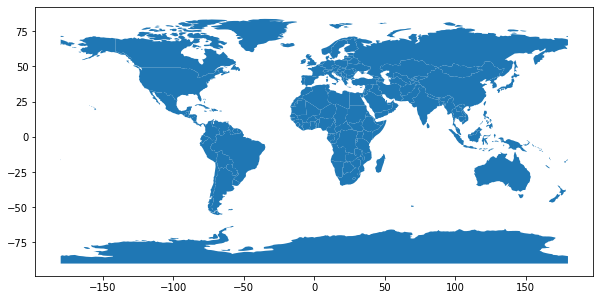

In [5]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.plot(figsize=(10, 5))
world

So now let's plot the data. The explanation is embedded in the code. For more information take a look at [GeoPandas Mapping](http://geopandas.org/mapping.html).

/home/sven/devel/emissions-api/sentinel5p-plots/env/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/sven/devel/emissions-api/sentinel5p-plots/env/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


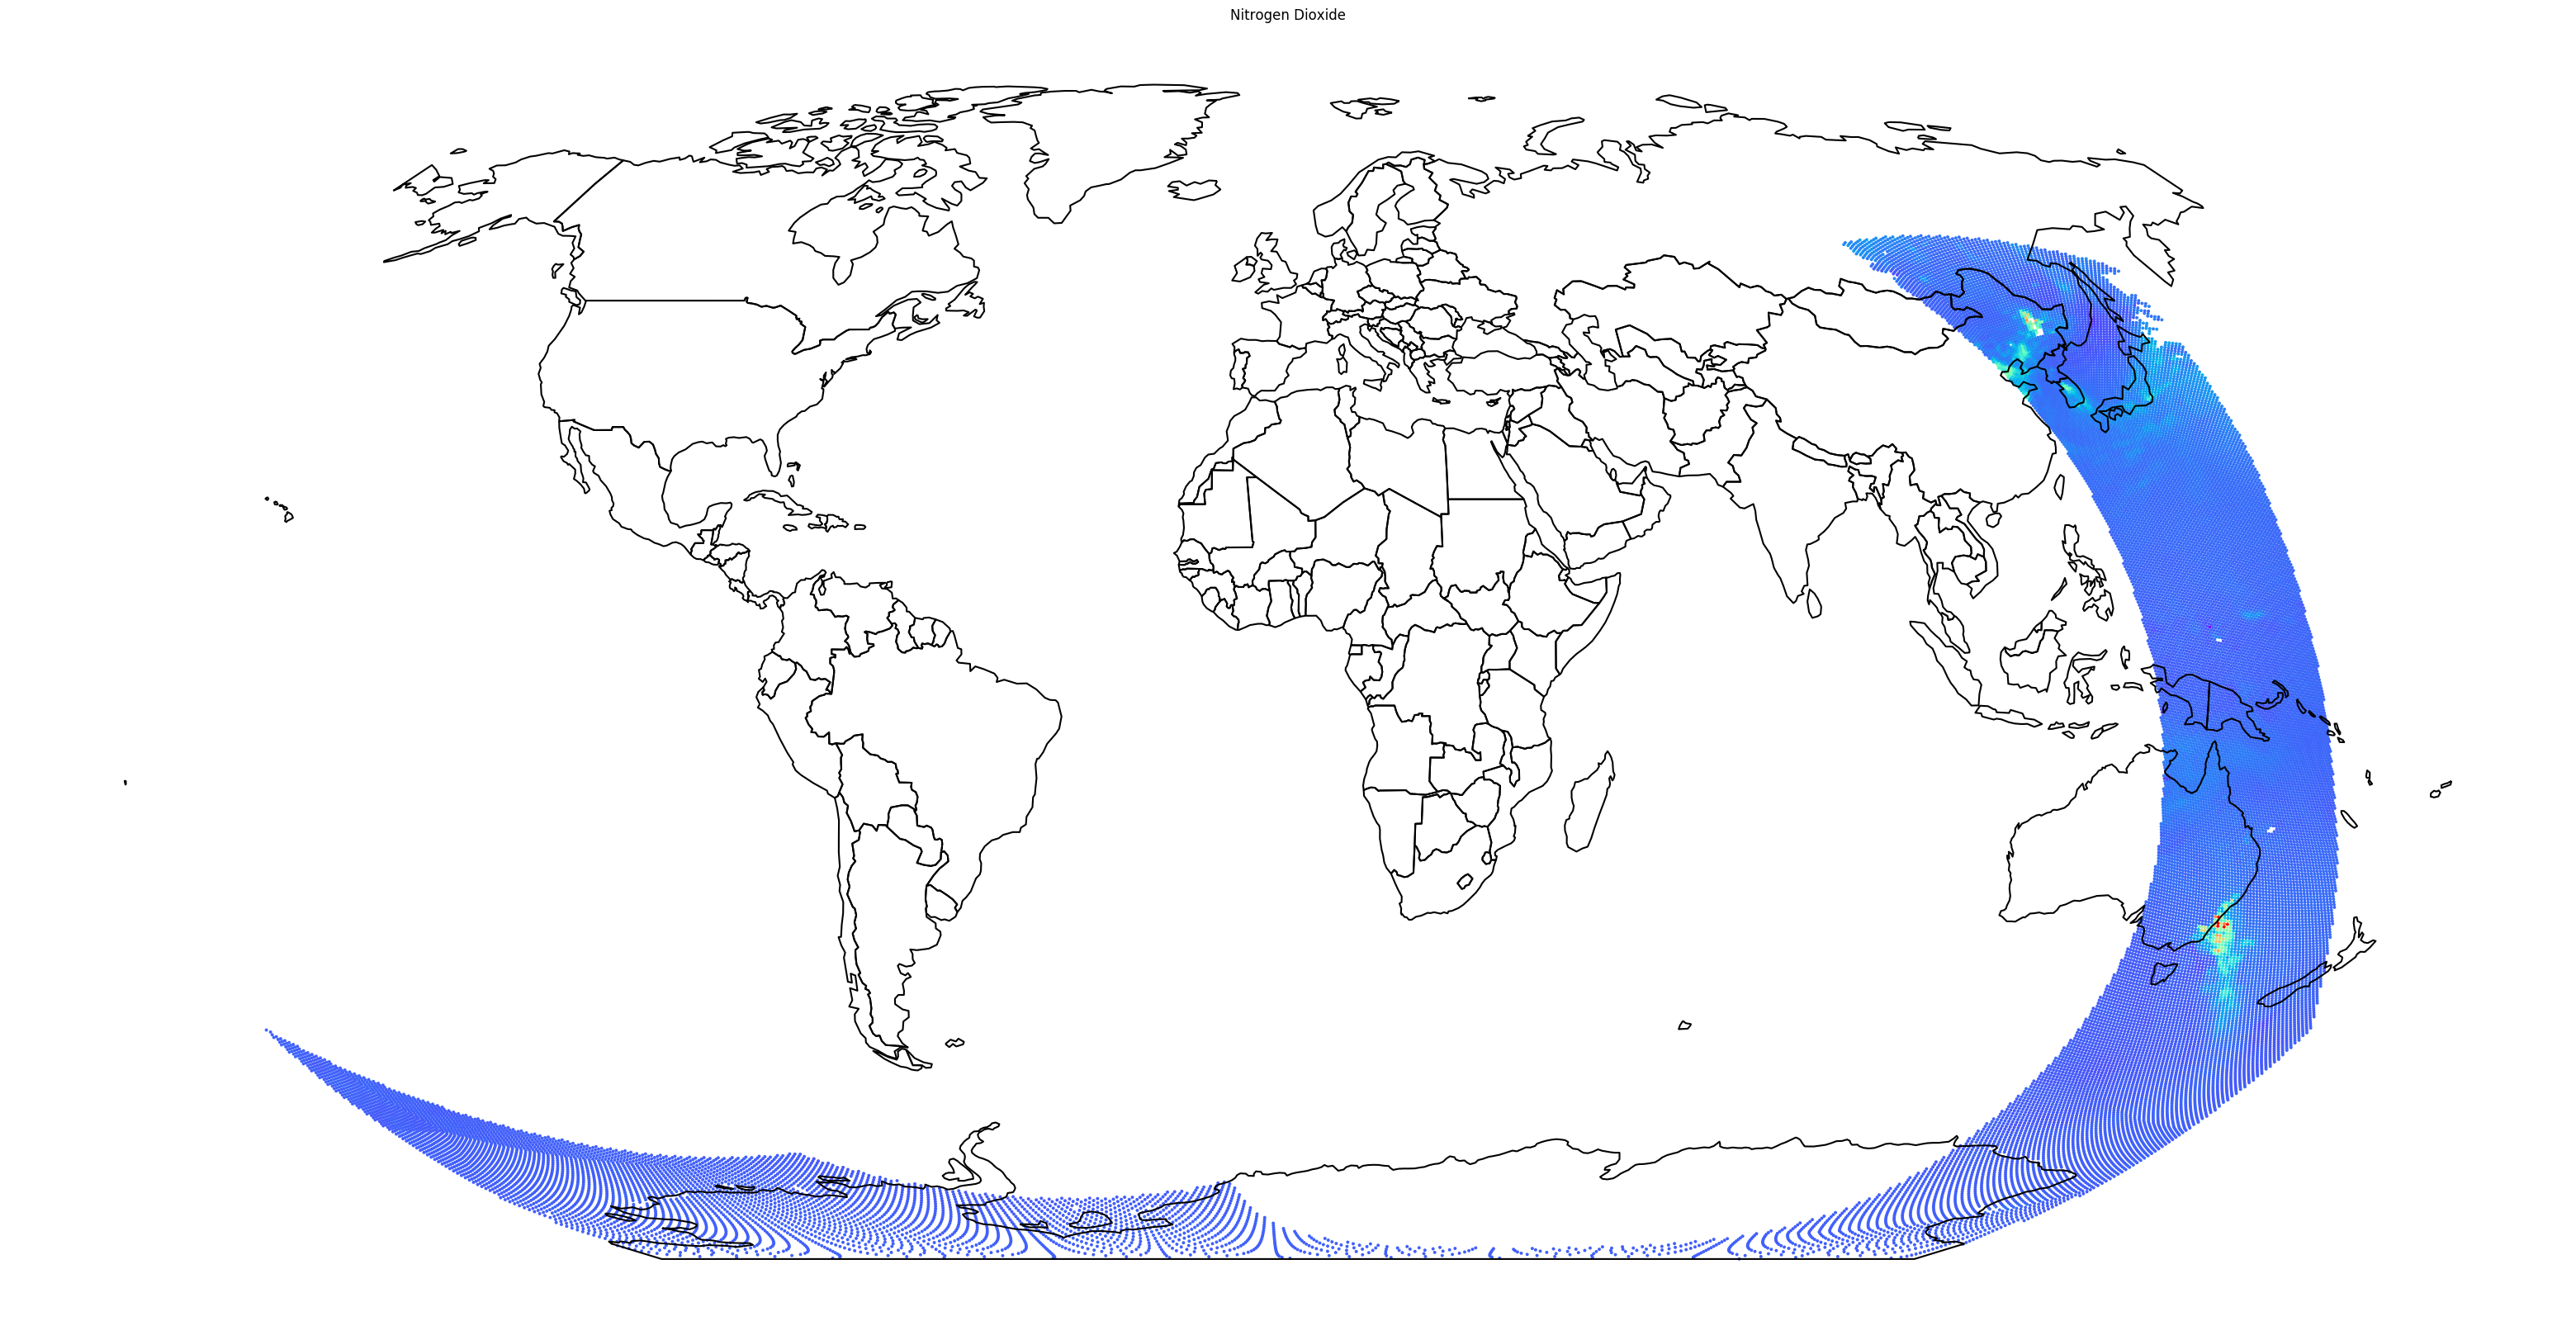

In [6]:
import matplotlib.pyplot as plt

# Define base of the plot.
fig, ax = plt.subplots(1, 1, figsize=(40, 40), dpi=100)
# Disable the axes
ax.set_axis_off()
# Set a title
plt.title('Nitrogen Dioxide')
# Plot the data
data.to_crs('+a=6378137.0 +proj=robin +lon_0=0 +no_defs').plot(
    column='value',  # Column defining the color
    cmap='rainbow',  # Colormap
    marker='H',  # marker layout. Here a Hexagon.
    markersize=4,
    ax=ax,  # Base
    vmax=0.0005,  # Used as max for normalize luminance data
)

# Plot the boundary of the countries on top
world.to_crs('+a=6378137.0 +proj=robin +lon_0=0 +no_defs').geometry.boundary.plot(color=None, edgecolor='black', ax=ax)

We can already see a lot on thos plot. For one we can see the movement of the satellite and we can see that we do not have any data points in the north. This is due to the fact that the satellites instruments need light to work and are using the sunlight for that. Since it is Winter, there is not enough sunlight in the north.

Also we can see a high peak of nitrogen dioxide on the south east of australia which are probably the bush fires.

## Plotting multiple Files

Now we use all data we downloaded before in a single plot. So we get a nice view over the nitrogene dioxide values over the whole world.

First we load all files and combine them using [Pandas `concat`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html). After that we are using the same techniques as before to reduce the data and create a `geopandas.geodataframe.GeoDataFrame`.

In [7]:
import glob

import pandas


data = []
for filename in glob.glob('data/S5P_OFFL_L2__NO2____/*.nc'):
    data.append(
        s5a.filter_by_quality(
            s5a.load_ncfile(filename)))

data = pandas.concat(data, ignore_index=True)

data = s5a.point_to_h3(data, resolution=4)
data = s5a.aggregate_h3(data)
data = s5a.h3_to_point(data)

geometry = geopandas.points_from_xy(data.longitude, data.latitude)
data = geopandas.GeoDataFrame(data, geometry=geometry, crs={'init' :'epsg:4326'})
data

h3                        timestamp  quality  \
0       8406491ffffffff 2019-12-31 14:16:20.205000+00:00     0.74   
1       8406493ffffffff 2019-12-31 14:16:16.005000+00:00     0.74   
2       8406497ffffffff 2019-12-31 14:16:22.725000+00:00     0.74   
3       8406499ffffffff 2019-12-31 14:16:17.685000+00:00     0.74   
4       840649bffffffff 2019-12-31 14:16:13.485000+00:00     0.74   
...                 ...                              ...      ...   
266010  84f3b65ffffffff 2019-12-31 01:46:35.687000+00:00     0.88   
266011  84f3b67ffffffff 2019-12-31 01:46:30.647000+00:00     0.73   
266012  84f3b69ffffffff 2019-12-31 01:46:44.927000+00:00     0.73   
266013  84f3b6bffffffff 2019-12-31 01:46:39.887000+00:00     0.66   
266014  84f3b6dffffffff 2019-12-31 01:46:43.247000+00:00     0.73   

               value   latitude   longitude                     geometry  
0      -3.061534e-06  58.179903  -35.448814   POINT (-35.44881 58.17990)  
1      -5.780260e-06  57.791207  -35.731777   POINT (-35.73178 57.79121)  
2      -4.721612e-06  58.103118  -36.189067   POINT (-36.18907 58.10312)  
3      -4.001487e-06  58.252078  -34.708711   POINT (-34.70871 58.25208)  
4      -5.343825e-06  57.865881  -34.999710   POINT (-34.99971 57.86588)  
...              ...        ...         ...                          ...  
266010  1.525187e-07 -78.894170  154.567087  POINT (154.56709 -78.89417)  
266011  2.320906e-07 -79.219329  155.644712  POINT (155.64471 -79.21933)  
266012 -3.834091e-08 -78.473878  157.304381  POINT (157.30438 -78.47388)  
266013  3.006751e-07 -78.789092  158.409090  POINT (158.40909 -78.78909)  
266014 -9.810239e-08 -78.524756  155.437410  POINT (155.43741 -78.52476)  

[266015 rows x 7 columns]

Now we plot this data the same we way than before.

/home/sven/devel/emissions-api/sentinel5p-plots/env/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/sven/devel/emissions-api/sentinel5p-plots/env/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


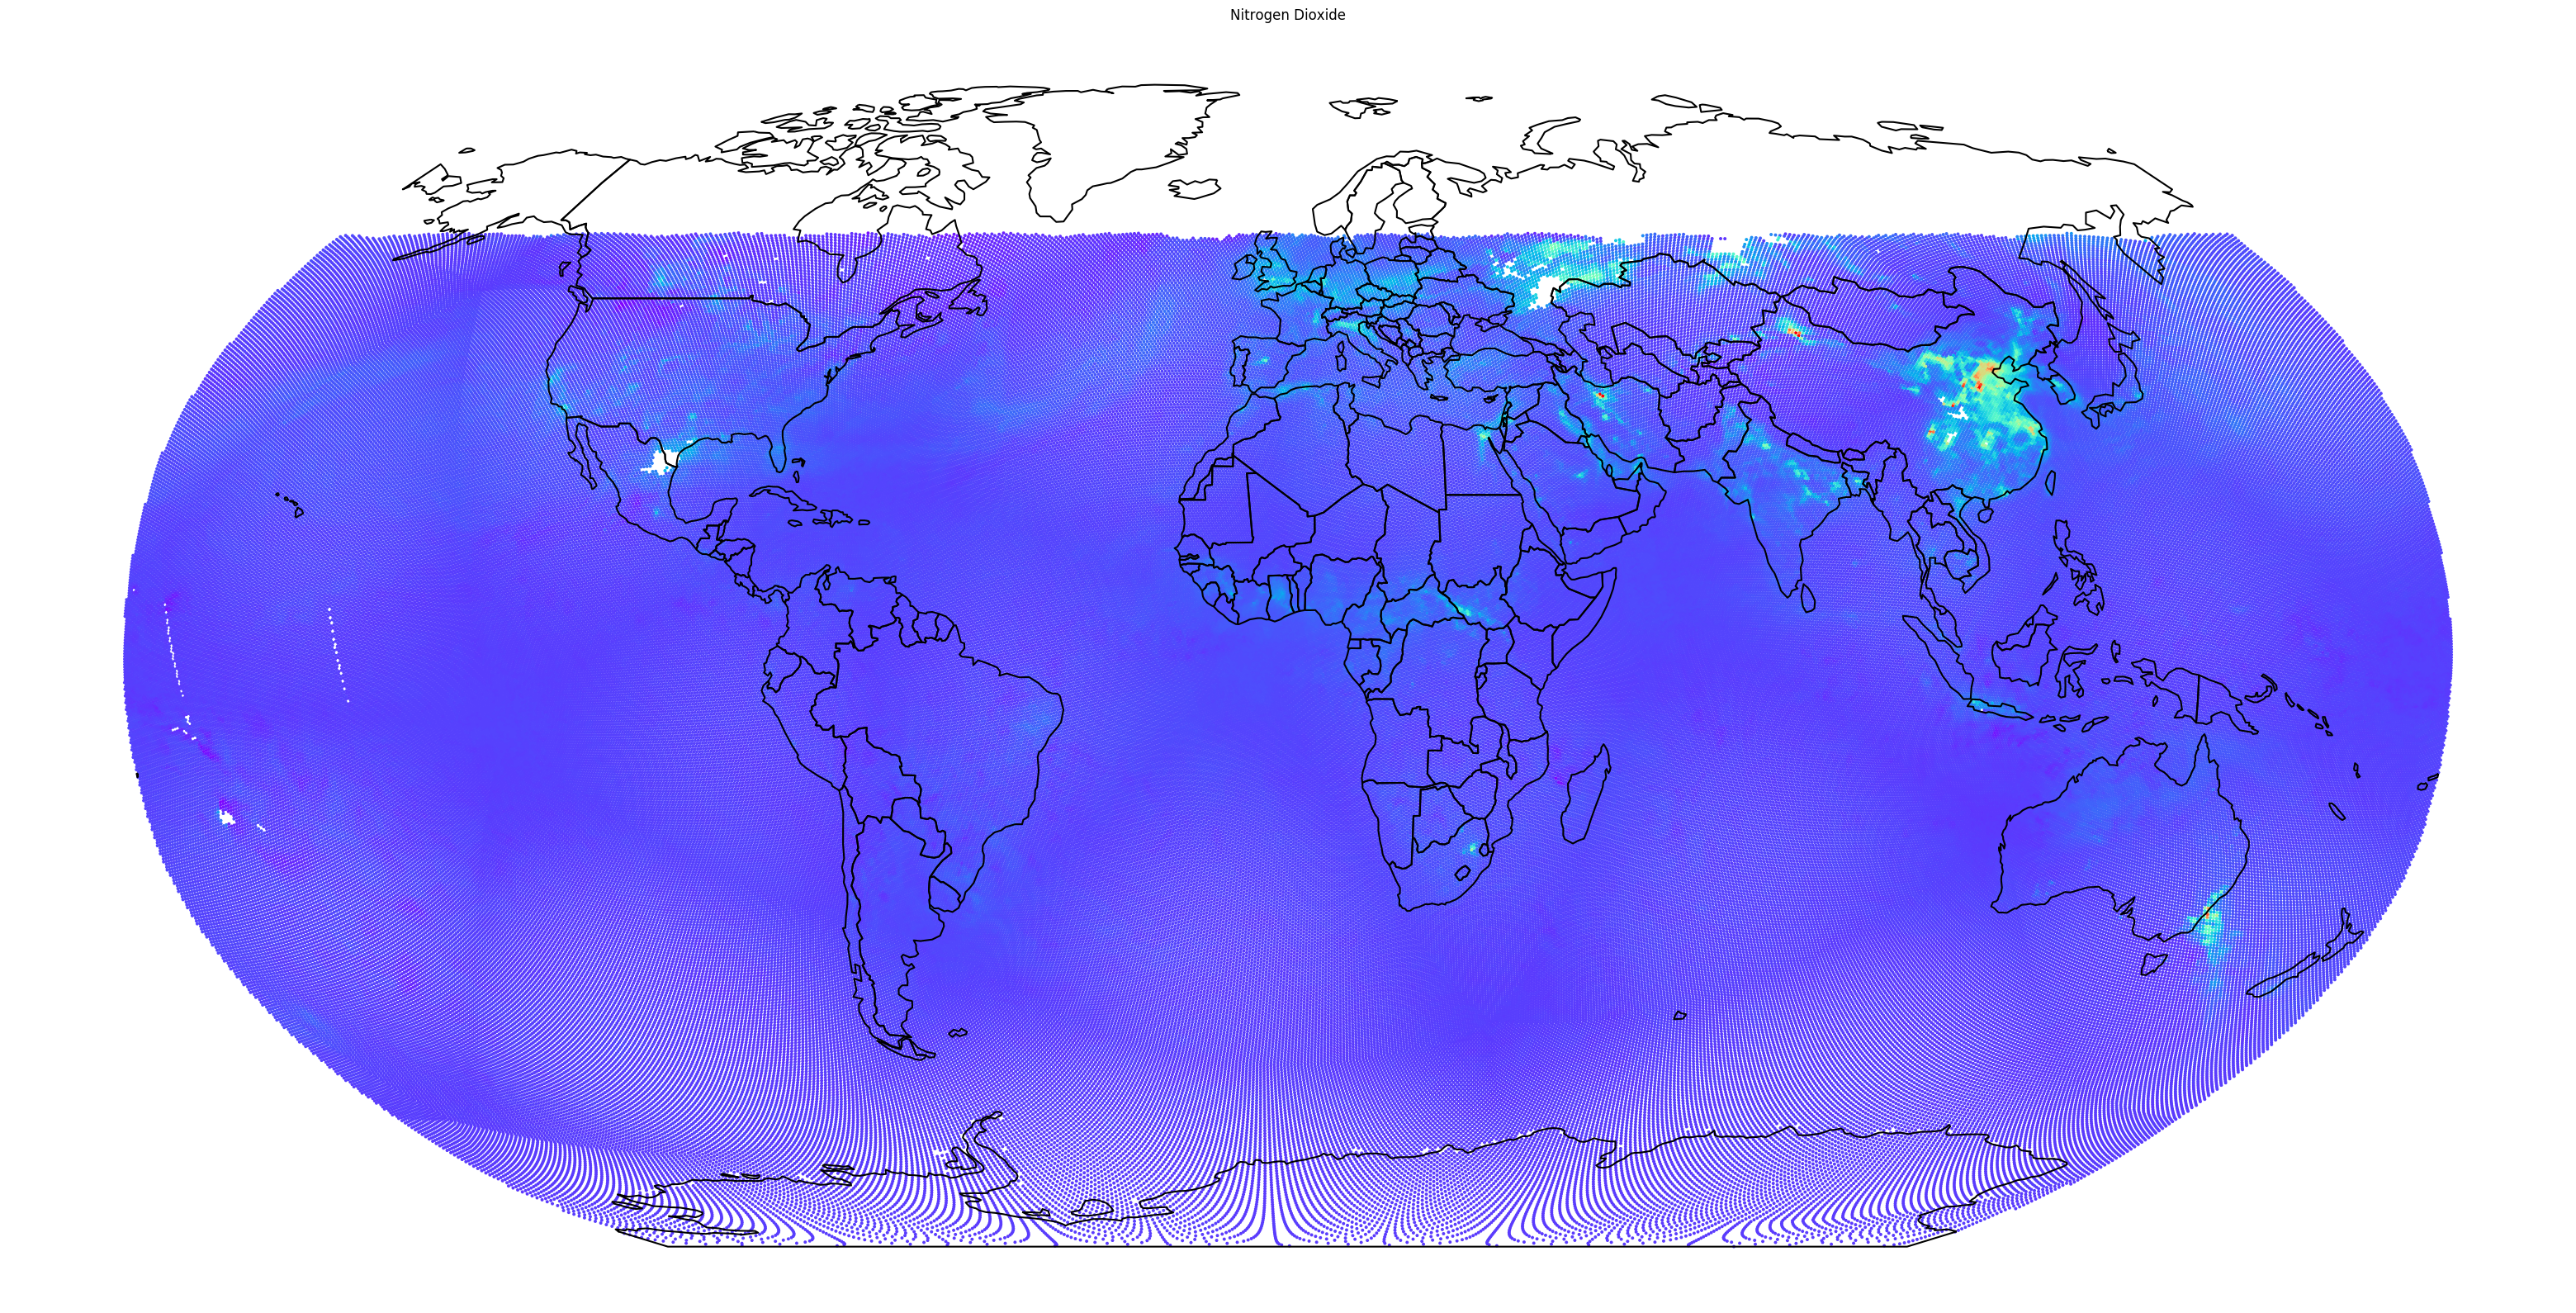

In [8]:
import matplotlib.pyplot as plt

# Define base of the plot.
fig, ax = plt.subplots(1, 1, figsize=(40, 40), dpi=100)
# Disable the axes
ax.set_axis_off()
# Set a title
plt.title('Nitrogen Dioxide')
# Plot the data
data.to_crs('+a=6378137.0 +proj=robin +lon_0=0 +no_defs').plot(
    column='value',  # Column defining the color
    cmap='rainbow',  # Colormap
    marker='H',  # marker layout. Here a Hexagon.
    markersize=4,
    ax=ax,  # Base
    vmax=0.0005,  # Used as max for normalize luminance data
)

# Plot the boundary of the countries on top
world.to_crs('+a=6378137.0 +proj=robin +lon_0=0 +no_defs').geometry.boundary.plot(color=None, edgecolor='black', ax=ax)